In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'sklearn'

## Load data

In [28]:

all_file = "../datasets/train.parquet"
train_df = pd.read_parquet(all_file)


* PreProcess the data

In [29]:
cols = list(train_df)[3:]
#Date and volume columns are not used in training.
print(cols)
train_df = train_df[cols].astype(float)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


In [30]:
scaler = StandardScaler()
scaler = scaler.fit(train_df)
train_df_scaled = scaler.transform(train_df)

In [1]:
#Empty lists to be populated using formatted training data


SPLIT = 0.8
trainX = []
trainY = []
testX = []
testY = []

#train_df_scaled = train_df_scaled.reshape((-1,1000,32))[0]
print(train_df_scaled.shape)
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 100  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)

grouped = train_df.groupby("seq_ix")
n_back = 100
train = []
test = []

for data_idx, group in grouped:
    group = group.drop(columns=['seq_ix','step_in_seq', 'need_prediction'])
    for time_step in range(n_back-1,999):
        window = group.iloc[time_step - n_back: time_step + 1]
        if not window.empty:
            train.append(window)

trainX, trainY = np.array(trainX), np.array(trainY)
trainX, testX = np.split(trainX, [int(SPLIT * len(trainX))])
trainY, testY = np.split(trainY, [int(SPLIT * len(trainY))])

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

NameError: name 'train_df_scaled' is not defined

**LSTM Training and Validation**

In [15]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=30, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

c:\Users\hwisa\anaconda3\envs\wunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,281 (145.63 KB)

 Trainable params: 37,281 (145.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
  923/23264 ━━━━━━━━━━━━━━━━━━━━ 3:19 9ms/step - loss: 1.6850

KeyboardInterrupt: 

**XGBoost Training and Validation**

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Reshape trainX to be 2D for XGBoost
trainX_reshaped = trainX.reshape(trainX.shape[0], -1)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(trainX_reshaped, trainY, test_size=0.1, random_state=42)

# Define and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, n_jobs=-1)

# Store evaluation results
eval_results = xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)],
              verbose=True)


# Evaluate the model
y_pred = xgb_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f"XGBoost Validation MSE: {mse}")

[0]	validation_0-rmse:0.84200	validation_1-rmse:0.89304
[1]	validation_0-rmse:0.80067	validation_1-rmse:0.85031
[2]	validation_0-rmse:0.76136	validation_1-rmse:0.80972
[3]	validation_0-rmse:0.72402	validation_1-rmse:0.77115
[4]	validation_0-rmse:0.68854	validation_1-rmse:0.73424
[5]	validation_0-rmse:0.65481	validation_1-rmse:0.69918
[6]	validation_0-rmse:0.62277	validation_1-rmse:0.66617
[7]	validation_0-rmse:0.59232	validation_1-rmse:0.63509
[8]	validation_0-rmse:0.56340	validation_1-rmse:0.60490
[9]	validation_0-rmse:0.53590	validation_1-rmse:0.57630
[10]	validation_0-rmse:0.50977	validation_1-rmse:0.54919
[11]	validation_0-rmse:0.48495	validation_1-rmse:0.52358
[12]	validation_0-rmse:0.46137	validation_1-rmse:0.49892
[13]	validation_0-rmse:0.43896	validation_1-rmse:0.47576
[14]	validation_0-rmse:0.41766	validation_1-rmse:0.45358
[15]	validation_0-rmse:0.39744	validation_1-rmse:0.43243
[16]	validation_0-rmse:0.37822	validation_1-rmse:0.41242
[17]	validation_0-rmse:0.35997	validation

**Price Prediction with test dataset**


In [ ]:
lstm_predictions = model.predict(testX)
# Reshape trainX to be 2D for XGBoost

testX_reshaped = testX.reshape(testX.shape[0], -1)
xgboost_predictions = xgb_model.predict(testX_reshaped)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [ ]:
# Reshape trainY to be 2-dimensional
testY_reshaped = testY.reshape(-1, 1)

# Create dummy arrays with the correct shape for inverse transform
dummy_testY = np.zeros((len(testY_reshaped), 4))
dummy_lstm_predictions = np.zeros((len(lstm_predictions), 4))
dummy_xgboost_predictions = np.zeros((len(xgboost_predictions), 4))

# Place the actual and predicted values into the first column of the dummy arrays
dummy_testY[:, 0] = testY_reshaped[:, 0]
dummy_lstm_predictions[:, 0] = lstm_predictions[:, 0]
dummy_xgboost_predictions[:, 0] = xgboost_predictions.reshape(-1, 1)[:, 0]

# Inverse transform the original scaled training data
testY_actual_unscaled = scaler.inverse_transform(dummy_testY)[:, 0]

# Inverse transform the LSTM predictions
lstm_predictions_unscaled = scaler.inverse_transform(dummy_lstm_predictions)[:, 0]

# Inverse transform the XGBoost predictions
xgboost_predictions_unscaled = scaler.inverse_transform(dummy_xgboost_predictions)[:, 0]

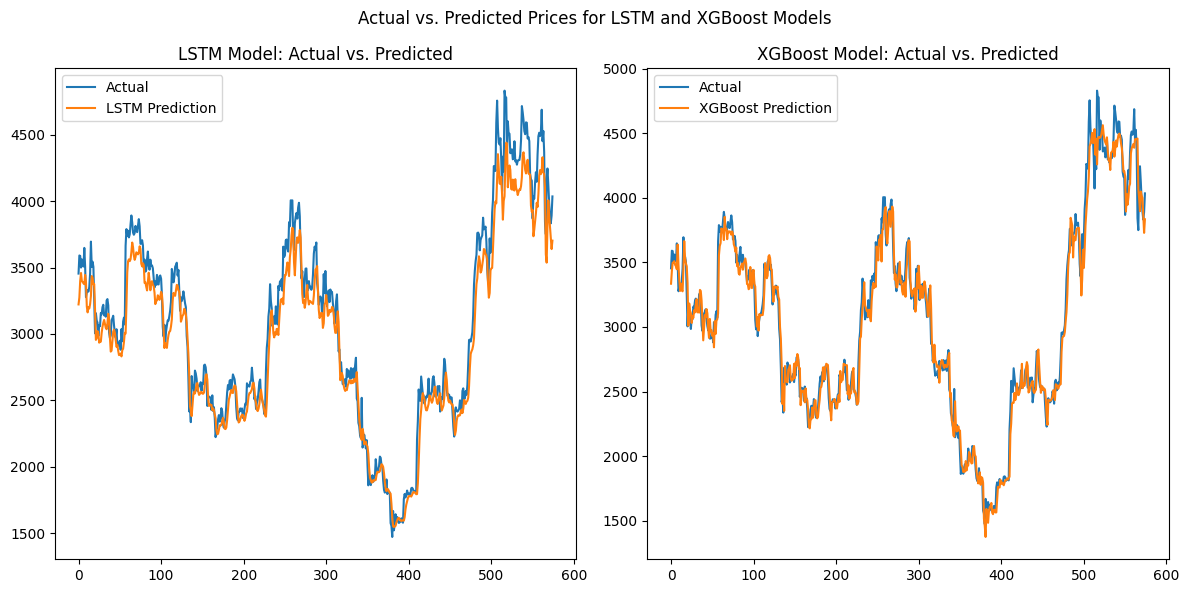

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(testY_actual_unscaled, label='Actual')
plt.plot(lstm_predictions_unscaled, label='LSTM Prediction')
plt.title('LSTM Model: Actual vs. Predicted')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(testY_actual_unscaled, label='Actual')
plt.plot(xgboost_predictions_unscaled, label='XGBoost Prediction')
plt.title('XGBoost Model: Actual vs. Predicted')
plt.legend()

plt.suptitle('Actual vs. Predicted Prices for LSTM and XGBoost Models')
plt.tight_layout()
plt.show()

In [ ]:
lstm_predictions_test = model.predict(testX)
testX_reshaped_for_xgb = testX.reshape(testX.shape[0], -1)
xgboost_predictions_test = xgb_model.predict(testX_reshaped_for_xgb)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


## Inverse scale predictions




**Reasoning**:
Inverse scale the predictions from both models to their original scale using dummy arrays and the fitted scaler.



In [ ]:
# Create dummy arrays with the correct shape for inverse transform
dummy_lstm_predictions_test = np.zeros((len(lstm_predictions_test), train_df_scaled.shape[1]))
dummy_xgboost_predictions_test = np.zeros((len(xgboost_predictions_test), train_df_scaled.shape[1]))

# Place the predicted values into the first column of the dummy arrays
dummy_lstm_predictions_test[:, 0] = lstm_predictions_test[:, 0]
dummy_xgboost_predictions_test[:, 0] = xgboost_predictions_test.reshape(-1, 1)[:, 0]

# Inverse transform the LSTM predictions
lstm_predictions_unscaled_test = scaler.inverse_transform(dummy_lstm_predictions_test)[:, 0]

# Inverse transform the XGBoost predictions
xgboost_predictions_unscaled_test = scaler.inverse_transform(dummy_xgboost_predictions_test)[:, 0]

In [ ]:
# Reshape testY to be 2-dimensional
testY_reshaped = testY.reshape(-1, 1)

# Create a dummy array with the correct shape for inverse transform
dummy_testY = np.zeros((len(testY_reshaped), train_df_scaled.shape[1]))

# Place the actual values into the first column of the dummy array
dummy_testY[:, 0] = testY_reshaped[:, 0]

# Inverse transform the original scaled test data
testY_actual_unscaled = scaler.inverse_transform(dummy_testY)[:, 0]

In [ ]:
daily_returns = pd.Series(testY_actual_unscaled).pct_change().dropna()

In [ ]:
lstm_signals = pd.Series(0, index=daily_returns.index)
xgboost_signals = pd.Series(0, index=daily_returns.index)

# Generate LSTM signals
# Signals are based on the prediction for day i and the actual price of day i-1
for i in range(1, len(lstm_predictions_unscaled_test)):
    if lstm_predictions_unscaled_test[i] > testY_actual_unscaled[i-1]:
        lstm_signals.iloc[i-1] = 1  # Buy signal for day i-1
    elif lstm_predictions_unscaled_test[i] < testY_actual_unscaled[i-1]:
        lstm_signals.iloc[i-1] = -1 # Sell signal for day i-1
    else:
        lstm_signals.iloc[i-1] = 0  # Hold signal

# Generate XGBoost signals
for i in range(1, len(xgboost_predictions_unscaled_test)):
    if xgboost_predictions_unscaled_test[i] > testY_actual_unscaled[i-1]:
        xgboost_signals.iloc[i-1] = 1 # Buy signal for day i-1
    elif xgboost_predictions_unscaled_test[i] < testY_actual_unscaled[i-1]:
        xgboost_signals.iloc[i-1] = -1 # Sell signal for day i-1
    else:
        xgboost_signals.iloc[i-1] = 0 # Hold signal

# Align signals with daily_returns
lstm_signals = lstm_signals[:len(daily_returns)]
xgboost_signals = xgboost_signals[:len(daily_returns)]


## Calculate daily p&l




In [ ]:
lstm_daily_pnl = lstm_signals * daily_returns
xgboost_daily_pnl = xgboost_signals * daily_returns

lstm_daily_allin_pnl = []
xgboost_daily_allin_pnl = []


balance = 1

for p_diff in lstm_daily_pnl:
  balance *= (1 + p_diff)
  lstm_daily_allin_pnl.append(balance)

balance = 1

for p_diff in xgboost_daily_pnl:
  balance *= (1 + p_diff)
  xgboost_daily_allin_pnl.append(balance)


xgboost_daily_allin_pnl = pd.DataFrame(xgboost_daily_allin_pnl)
lstm_daily_allin_pnl = pd.DataFrame(lstm_daily_allin_pnl)



In [ ]:
lstm_accumulated_pnl = lstm_daily_pnl.cumsum()
xgboost_accumulated_pnl = xgboost_daily_pnl.cumsum()
lstm_accumulated_allin_pnl = lstm_daily_allin_pnl.cumsum()
xgboost_accumulated_allin_pnl = xgboost_daily_allin_pnl.cumsum()

print(f"LSTM Accumulated P&L: {lstm_accumulated_pnl.iloc[-1]:.4f}")
print(f"XGBoost Accumulated P&L: {xgboost_accumulated_pnl.iloc[-1]:.4f}")



LSTM Accumulated P&L: 0.1427
XGBoost Accumulated P&L: 0.7804


## Visualize p&l



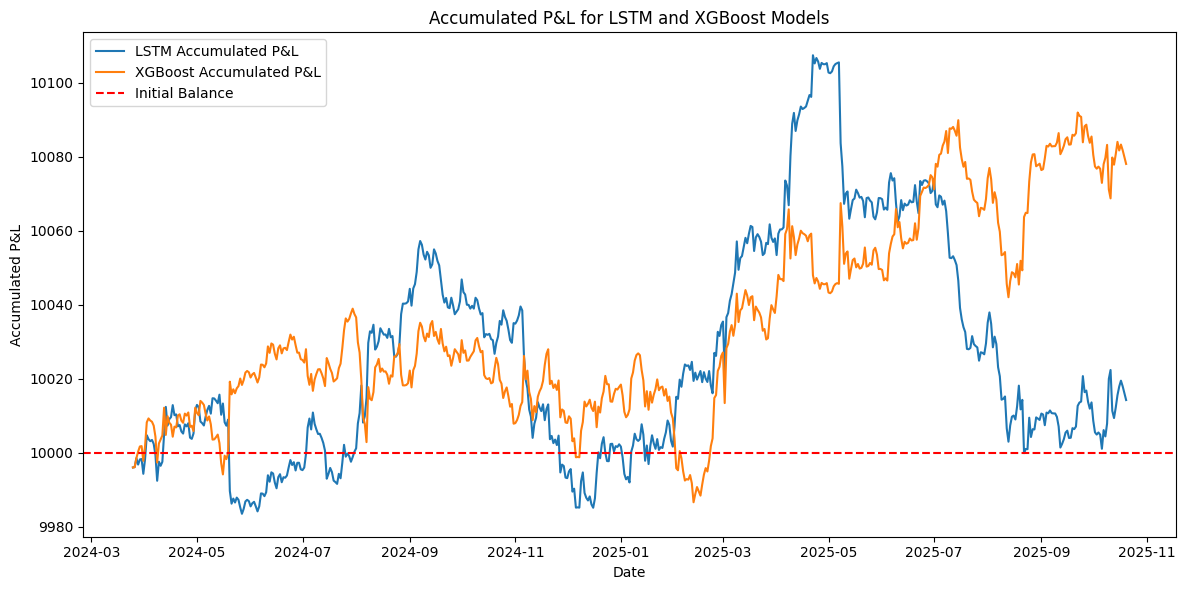

DatetimeIndex(['2024-03-24', '2024-03-25', '2024-03-26', '2024-03-27',
               '2024-03-28', '2024-03-29', '2024-03-30', '2024-03-31',
               '2024-04-01', '2024-04-02',
               ...
               '2025-10-10', '2025-10-11', '2025-10-12', '2025-10-13',
               '2025-10-14', '2025-10-15', '2025-10-16', '2025-10-17',
               '2025-10-18', '2025-10-20'],
              dtype='datetime64[ns]', name='Date', length=575, freq=None)

In [ ]:
initial_balance = 10000

# Get the dates for the test set
# The test set starts after the training set split point
test_dates = ETH.index[len(trainY) + n_past:]


fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot P&L on the primary y-axis using test dates
ax1.plot(test_dates[1:], initial_balance + lstm_accumulated_pnl*100, label='LSTM Accumulated P&L')
ax1.plot(test_dates[1:], initial_balance + xgboost_accumulated_pnl*100, label='XGBoost Accumulated P&L')

ax1.set_xlabel('Date')
ax1.set_ylabel('Accumulated P&L')
ax1.axhline(y=initial_balance, color='r', linestyle='--', label='Initial Balance')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')



plt.title('Accumulated P&L for LSTM and XGBoost Models')
fig.tight_layout()
plt.show()
test_dates

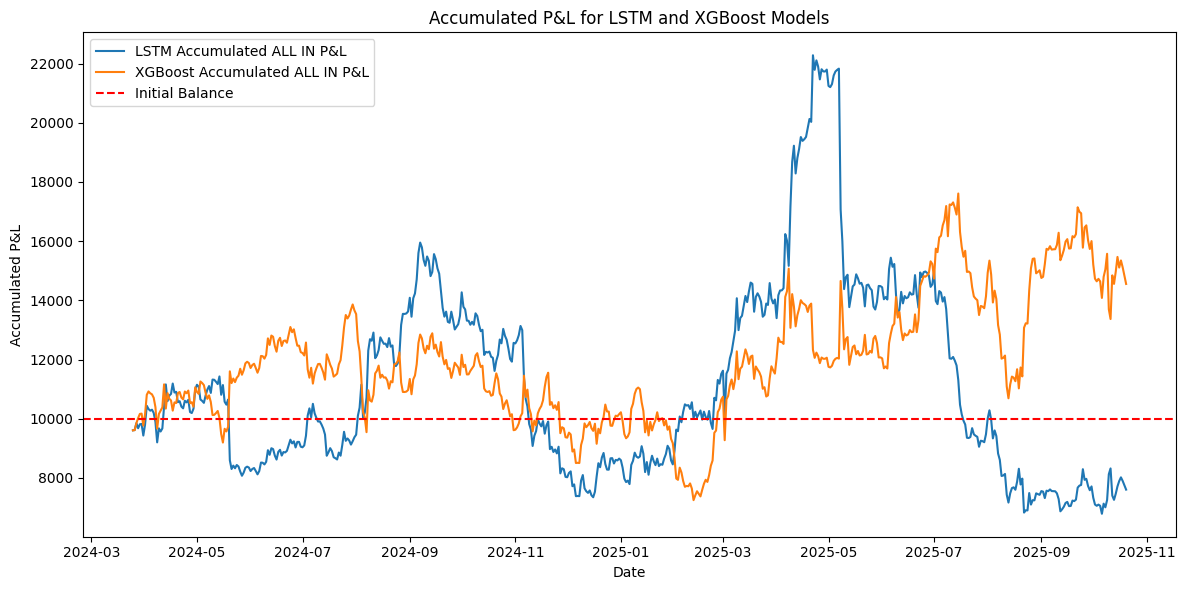

DatetimeIndex(['2024-03-24', '2024-03-25', '2024-03-26', '2024-03-27',
               '2024-03-28', '2024-03-29', '2024-03-30', '2024-03-31',
               '2024-04-01', '2024-04-02',
               ...
               '2025-10-10', '2025-10-11', '2025-10-12', '2025-10-13',
               '2025-10-14', '2025-10-15', '2025-10-16', '2025-10-17',
               '2025-10-18', '2025-10-20'],
              dtype='datetime64[ns]', name='Date', length=575, freq=None)

In [ ]:
initial_balance = 10000

# Get the dates for the test set
# The test set starts after the training set split point
test_dates = ETH.index[len(trainY) + n_past:]


fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(test_dates[1:], initial_balance* lstm_daily_allin_pnl, label='LSTM Accumulated ALL IN P&L')
ax1.plot(test_dates[1:], initial_balance* xgboost_daily_allin_pnl, label='XGBoost Accumulated ALL IN P&L')

ax1.set_xlabel('Date')
ax1.set_ylabel('Accumulated P&L')
ax1.axhline(y=initial_balance, color='r', linestyle='--', label='Initial Balance')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')



plt.title('Accumulated P&L for LSTM and XGBoost Models')
fig.tight_layout()
plt.show()
test_dates